# Vibe Coding: Real-World Data Cleaning Challenge

## The Mission

You're a Data Analyst at **TechSalary Insights**. Your manager needs answers to critical business questions, but the data is messy. Your job is to clean it and provide accurate insights.

**The catch:** You must figure out how to clean the data yourself. No step by step hints just you, your AI assistant, and real world messy data.

---

## The Dataset: Ask A Manager Salary Survey 2021

**Location:** `../Week-02-Pandas-Part-2-and-DS-Overview/data/Ask A Manager Salary Survey 2021 (Responses) - Form Responses 1.tsv`

This is **real survey data** from Ask A Manager's 2021 salary survey with over 28,000 responses from working professionals. The data comes from this survey: https://www.askamanager.org/2021/04/how-much-money-do-you-make-4.html

**Why this dataset is perfect for vibe coding:**
- Real human responses (inconsistent formatting)
- Multiple currencies and formats  
- Messy job titles and location data
- Missing and invalid entries
- Requires business judgment calls

---

## Your Business Questions

Answer these **exact questions** with clean data. There's only one correct answer for each:

### Core Questions (Required):
1. **What is the median salary for Software Engineers in the United States?** 
2. **Which US state has the highest average salary for tech workers?**
3. **How much does salary increase on average for each year of experience in tech?**
4. **Which industry (besides tech) has the highest median salary?**

### Bonus Questions (If time permits):
5. **What's the salary gap between men and women in tech roles?**
6. **Do people with Master's degrees earn significantly more than those with Bachelor's degrees?**

**Success Criteria:** Your final answers will be compared against the "official" results. Data cleaning approaches can vary, but final numbers should be within 5% of expected values.


---
# Your Work Starts Here

## Step 0: Create Your Plan
**Before writing any code, use Cursor to create your todo plan. Then paste it here:**

## My Data Cleaning Plan

*(Paste your Cursor todo list here)*

- [ ] Import necessary libraries (pandas, numpy, matplotlib, seaborn)
- [ ] Load the dataset from the specified TSV file into a pandas DataFrame
- [ ] Explore the dataset to understand its structure, including columns and data types
- [ ] Identify and handle missing values in key columns (e.g., Salary, Job Title, Location)
- [ ] Standardize job titles to ensure consistency (e.g., "Software Engineer", "SWE", "Software Eng.")
- [ ] Convert all salary values to a common currency (e.g., USD) and format (e.g., annual salary)
- [ ] Extract relevant information from location data (e.g., city, state, country)
- [ ] Create new columns if necessary (e.g., years of experience, education level)
- [ ] Filter the dataset to include only relevant tech roles for specific analyses
- [ ] Calculate the median salary for Software Engineers in the United States
- [ ] Determine which US state has the highest average salary for tech workers
- [ ] Analyze the relationship between years of experience and salary increase in tech roles
- [ ] Identify the industry with the highest median salary outside of tech
- [ ] (Bonus) Calculate the salary gap between men and women in tech roles
- [ ] (Bonus) Compare salaries of individuals with Master's degrees versus those with Bachelor's degrees


## Step 1: Data Loading and Exploration

Start here! Load the dataset and get familiar with what you're working with.


In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from thefuzz import process, fuzz
from concurrent.futures import ThreadPoolExecutor
from collections import defaultdict, Counter
import pandas as pd
import statsmodels.api as sm

# Load the dataset
df = pd.read_csv('..\\..\\Week-02-Pandas-Part-2-and-DS-Overview\\data\\Ask A Manager Salary Survey 2021 (Responses) - Form Responses 1.tsv', sep='\t')

# Display the first few rows of the dataframe
df.head(5)

,Timestamp,How old are you?,What industry do you work in?,Job title,"If your job title needs additional context, please clarify here:","What is your annual salary? (You'll indicate the currency in a later question. If you are part-time or hourly, please enter an annualized equivalent -- what you would earn if you worked the job 40 hours a week, 52 weeks a year.)","How much additional monetary compensation do you get, if any (for example, bonuses or overtime in an average year)? Please only include monetary compensation here, not the value of benefits.",Please indicate the currency,"If ""Other,"" please indicate the currency here:","If your income needs additional context, please provide it here:",What country do you work in?,"If you're in the U.S., what state do you work in?",What city do you work in?,How many years of professional work experience do you have overall?,How many years of professional work experience do you have in your field?,What is your highest level of education completed?,What is your gender?,What is your race? (Choose all that apply.)
0,4/27/2021 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,"55,000",0.0,USD,NaN,NaN,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White
1,4/27/2021 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,NaN,"54,600",4000.0,GBP,NaN,NaN,United Kingdom,NaN,Cambridge,8 - 10 years,5-7 years,College degree,Non-binary,White
2,4/27/2021 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,NaN,"34,000",NaN,USD,NaN,NaN,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White
3,4/27/2021 11:02:41,25-34,Nonprofits,Program Manager,NaN,"62,000",3000.0,USD,NaN,NaN,USA,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White
4,4/27/2021 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,NaN,"60,000",7000.0,USD,NaN,NaN,US,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White


## Step 2: Data Cleaning


In [6]:
def consolidate_strings_canonical(df, column, threshold=80, max_workers=8, inplace=True):
    """
    Consolidates similar strings in a DataFrame column using fuzzy matching.
    The most frequent variant becomes the canonical name for each cluster.
    
    Args:
        df: DataFrame to modify
        column: Column name to consolidate
        threshold: Fuzzy matching threshold (0-100)
        max_workers: Number of parallel workers
        inplace: If True, replaces original column; if False, creates new column with '_clean' suffix
    """
    # Drop NA and get value counts
    value_counts = df[column].dropna().value_counts()
    unique_values = list(value_counts.index)
    
    clusters = {}
    canonical_names = {}

    # Step 1: Build clusters of similar strings
    for val in unique_values:
        if val in clusters:
            continue
        cluster = [val]
        for other_val in unique_values:
            if other_val == val:
                continue
            if fuzz.ratio(val, other_val) >= threshold:
                cluster.append(other_val)
        for item in cluster:
            clusters[item] = cluster

    # Step 2: Pick most frequent variant as canonical
    for val, cluster in clusters.items():
        canonical_names[val] = max(cluster, key=lambda x: value_counts.get(x, 0))

    # Step 3: Map values in parallel
    def map_value(x):
        return canonical_names.get(x, x)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(map_value, df[column]))

    # Replace in-place or create new column
    if inplace:
        df[column] = results
    else:
        df[f"{column}_clean"] = results
    
    return df

In [7]:
# Create a copy of the original dataframe for cleaning iterations
df_clean = df.copy()

# Now that we see the data, we can start cleaning it and analyzing it.
# We will start cleaning by renaming columns to make them easier to work with.
df_clean.columns = df_clean.columns.str.strip()
df_clean.rename(columns={
    'How old are you?': 'age',
    'What industry do you work in?': 'industry',
    'Job title': 'job_title',
    'If your job title needs additional context, please clarify here:': 'job_title_context',
    'What is your annual salary? (You\'ll indicate the currency in a later question. If you are part-time or hourly, please enter an annualized equivalent -- what you would earn if you worked the job 40 hours a week, 52 weeks a year.)': 'annual_salary',
    'How much additional monetary compensation do you get, if any (for example, bonuses or overtime in an average year)? Please only include monetary compensation here, not the value of benefits.': 'additional_compensation',
    'Please indicate the currency': 'currency',
    'If "Other," please indicate the currency here:': 'currency_other',
    'If your income needs additional context, please provide it here:': 'income_context',
    'What country do you work in?': 'country',
    'If you\'re in the U.S., what state do you work in?': 'us_state',
    'What city do you work in?': 'city',
    'How many years of professional work experience do you have overall?': 'years_experience',
    'How many years of professional work experience do you have in your field?': 'years_experience_field',
    'What is your highest level of education completed?': 'education_level',
    'What is your gender?': 'gender',
    'What is your race? (Choose all that apply.)': 'race'
}, inplace=True)

# We want to convert the 'annual_salary' and 'additional_compensation' columns to numeric values.
# First, we will remove any commas and dollar signs, then convert to numeric.
df_clean['annual_salary'] = df_clean['annual_salary'].replace({'\$': '', ',': ''}, regex=True)
df_clean['additional_compensation'] = df_clean['additional_compensation'].replace({'\$': '', ',': ''}, regex=True)
df_clean['annual_salary'] = pd.to_numeric(df_clean['annual_salary'], errors='coerce')
df_clean['additional_compensation'] = pd.to_numeric(df_clean['additional_compensation'], errors='coerce')

# Instead of trying to fix all the various attempts to write "USA" wrong, we'll assume that if the entry contains a us_state, it's USA.
mask_us = df_clean['us_state'].notna() & df_clean['country'].notna()
df_clean.loc[mask_us, 'country'] = 'USA'

# We also will ignore entries which contain more than one state:
df_clean = df_clean[~df_clean['us_state'].str.contains(',', na=False)]

# We will clean up the industry column using fuzzy matching to consolidate similar entries.
df_clean = consolidate_strings_canonical(df_clean, 'industry', threshold=80, max_workers=8, inplace=True)

# From experience, we can drop 'years' to turn entries like '5-7 years' into '5-7'.
df_clean['years_experience'] = df_clean['years_experience'].str.replace(' years', '', regex=False)
df_clean['years_experience_field'] = df_clean['years_experience_field'].str.replace(' years', '', regex=False)

# Clean up the years_experience_field column to handle various formats
df_clean['years_experience_field'] = df_clean['years_experience_field'].str.replace('1 year or less', '0-1', regex=False)
df_clean['years_experience_field'] = df_clean['years_experience_field'].str.replace('41 or more', '41+', regex=False)

# # The survey is from 2021, so when we calculate currency conversion, we will use 2021 exchange rates.

# Create a mapping of currency codes to USD conversion rates (2021 average rates). We'll drop currencies that are too ambiguous or rare.
# Rates are approximate averages for 2021.
currency_to_usd = {
    'USD': 1,
    'CAD': 0.716856,
    'GBP': 1.347577,
    'EUR': 1.172583,
    'AUD/NZD': 0.620828,  # Average of AUD and NZD
    'CHF': 1.252801,
    'SEK': 0.106628,
    'JPY': 0.006797,
    'ZAR': 0.058093
}


# Function to convert salary to USD
def convert_to_usd(row):
    currency = row['currency']
    salary = row['annual_salary']
    additional_comp = row['additional_compensation']
    
    if pd.isna(currency) or pd.isna(salary):
        return np.nan, np.nan
    
    if currency in currency_to_usd:
        rate = currency_to_usd[currency]
        salary_usd = salary * rate
        additional_comp_usd = additional_comp * rate if pd.notna(additional_comp) else np.nan
        return salary_usd, additional_comp_usd
    else:
        return np.nan, np.nan

# Apply the conversion function
df_clean[['annual_salary_usd', 'additional_compensation_usd']] = df_clean.apply(convert_to_usd, axis=1, result_type='expand')

# Replace the original salary columns with USD values and update currency
df_clean['annual_salary'] = df_clean['annual_salary_usd']
df_clean['additional_compensation'] = df_clean['additional_compensation_usd']
df_clean['currency'] = 'USD'

# Drop the temporary USD columns since we've replaced the originals
df_clean.drop(['annual_salary_usd', 'additional_compensation_usd'], axis=1, inplace=True)

# Because we really only care about everything else in relation to salary, we aught to drop rows without salary data.
df_clean = df_clean[df_clean['annual_salary'].notna()]

# We need to normalize job titles.

def clean_title(title):
    if pd.isna(title):
        return ''
    title = title.lower().strip()
    title = re.sub(r'&', ' and ', title)  # replace & with 'and'
    title = re.sub(r'[^a-z0-9\s]', '', title)  # remove punctuation
    title = re.sub(r'\s+', ' ', title)  # normalize spaces
    return title

df_clean['job_title'] = df_clean['job_title'].apply(clean_title)

# Display the cleaned dataframe
df_clean.head(25).transpose()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Timestamp,4/27/2021 11:02:10,4/27/2021 11:02:22,4/27/2021 11:02:38,4/27/2021 11:02:41,4/27/2021 11:02:42,4/27/2021 11:02:46,4/27/2021 11:02:51,4/27/2021 11:03:00,4/27/2021 11:03:01,4/27/2021 11:03:02,...,4/27/2021 11:03:11,4/27/2021 11:03:13,4/27/2021 11:03:19,4/27/2021 11:03:21,4/27/2021 11:03:23,4/27/2021 11:03:24,4/27/2021 11:03:24,4/27/2021 11:03:27,4/27/2021 11:03:29,4/27/2021 11:03:31
age,25-34,25-34,25-34,25-34,25-34,25-34,25-34,25-34,45-54,35-44,...,35-44,35-44,45-54,35-44,35-44,25-34,35-44,35-44,35-44,25-34
industry,Education (Higher Education),Computing or Tech,"Accounting, Banking & Finance",Nonprofits,"Accounting, Banking & Finance",Education (Higher Education),Publishing,Education (Primary/Secondary),Computing or Tech,"Accounting, Banking & Finance",...,Utilities & Telecommunications,Business or Consulting,Art & Design,Business or Consulting,Education (Higher Education),Health care,Nonprofits,Nonprofits,Government and Public Administration,Public Library
job_title,research and instruction librarian,change and internal communications manager,marketing specialist,program manager,accounting manager,scholarly publishing librarian,publishing assistant,librarian,systems analyst,senior accountant,...,quality and compliance specialist,executive assistant,graphic designer,senior manager,assistant director of academic advising,data programmer analyst,program coordinator and assistant editor,event planner,researcher,teen librarian
job_title_context,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"High school, FT",Data developer/ETL Developer,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_salary,55000.0,73577.7042,34000.0,62000.0,60000.0,62000.0,33000.0,50000.0,112000.0,45000.0,...,32341.848,85000.0,59000.0,98000.0,54000.0,74000.0,50000.0,45161.928,96000.0,44500.0
additional_compensation,0.0,5390.308,NaN,3000.0,7000.0,NaN,2000.0,NaN,10000.0,0.0,...,673.7885,5000.0,NaN,1000.0,NaN,0.0,NaN,NaN,1000.0,0.0
currency,USD,USD,USD,USD,USD,USD,USD,USD,USD,USD,...,USD,USD,USD,USD,USD,USD,USD,USD,USD,USD
currency_other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
income_context,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I work for a Charter School,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step 3: Business Questions Analysis

Now answer those important business questions!


In [8]:
# Question 1: What is the median salary for Software Engineers in the United States?

swe_mask = (df_clean['job_title'].str.contains('software engineer', case=False)) & (df_clean['country'] == 'USA')
median_swe_salary = df_clean.loc[swe_mask, 'annual_salary'].median()
print(f"The median salary for Software Engineers in the United States is: ${median_swe_salary:,.2f}")

The median salary for Software Engineers in the United States is: $145,000.00


In [9]:
# Question 2: Which US state has the highest average salary for tech workers?

tech_mask = df_clean['industry'].str.contains('tech', case=False, na=False) & (df_clean['country'] == 'USA')

# Calculate average salary by state for tech workers. State field must have only one state name.
state_avg_salaries = df_clean.loc[tech_mask].groupby('us_state')['annual_salary'].mean().dropna()
if not state_avg_salaries.empty:
    highest_avg_state = state_avg_salaries.idxmax()
    highest_avg_salary = state_avg_salaries.max()
    print(f"The US state with the highest average salary for tech workers is {highest_avg_state} with an average salary of ${highest_avg_salary:,.2f}.")

The US state with the highest average salary for tech workers is Florida with an average salary of $157,457.23.


In [10]:
# Question 3: How much does salary increase on average for each year of experience in tech?

# This question is somewhat difficult to answer because our data for 'years_experience_field' is a range, such as '5-7' or '2 - 4'
# The solution I prefer is take the average value of years, assuming it will balance out in the end.

# Function to convert ranges to average years
def average_years(exp_range):
    if pd.isna(exp_range):
        return np.nan
    match = re.match(r'(\d+)\s*-\s*(\d+)', exp_range)
    if match:
        low, high = map(int, match.groups())
        return (low + high) / 2
    if '+' in exp_range:  # Handle "41+" as 41
        return float(exp_range.replace('+',''))
    try:
        return float(exp_range)
    except ValueError:
        return np.nan

# Apply function
df_clean['avg_years_experience_field'] = df_clean['years_experience_field'].apply(average_years)

# Filter for tech roles, non-missing years, reasonable experience & salaries
tech_exp_mask = tech_mask & df_clean['avg_years_experience_field'].notna()
df_tech = df_clean.loc[tech_exp_mask].copy()
df_tech = df_tech[
    (df_tech['avg_years_experience_field'] <= 30) &  # limit extreme experience
    (df_tech['annual_salary'] <= 250000)             # limit extreme salaries
]

# Linear regression
X = sm.add_constant(df_tech['avg_years_experience_field'])
y = df_tech['annual_salary']
model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          annual_salary   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     526.1
Date:                Sun, 12 Oct 2025   Prob (F-statistic):          5.74e-109
Time:                        19:57:17   Log-Likelihood:                -44761.
No. Observations:                3696   AIC:                         8.953e+04
Df Residuals:                    3694   BIC:                         8.954e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [12]:
# Question 4: What percentage of respondents work remotely vs. in-office?

# Unfortunately, this dataset doesn't appear to have a specific question about remote vs. in-office work.
# The 2021 Ask A Manager salary survey focused on salary, demographics, and job details, 
# but didn't include a dedicated question about work location arrangements.

# Let's double-check by looking for any clues in job titles or other fields
print("Searching for remote work indicators across multiple fields...")

# Check job title context for remote indicators
job_title_context_remote = df_clean['job_title_context'].fillna('').str.lower()
context_mentions = job_title_context_remote.str.contains('remote|wfh|work from home|virtual', regex=True)

# Check job titles for remote indicators
job_title_remote = df_clean['job_title'].fillna('').str.lower()
title_remote = job_title_remote.str.contains('remote|wfh|work from home|virtual', regex=True)

# Check income context for remote mentions
income_context_remote = df_clean['income_context'].fillna('').str.lower()
income_context_mentions = income_context_remote.str.contains('remote|wfh|work from home|virtual', regex=True)

# Combine all remote indicators
total_remote_indicators = context_mentions | title_remote | income_context_mentions

print(f"Remote mentions in job_title_context: {context_mentions.sum()}")
print(f"Remote mentions in job_title: {title_remote.sum()}")
print(f"Remote mentions in income_context: {income_context_mentions.sum()}")
print(f"Total unique remote indicators: {total_remote_indicators.sum()}")
print(f"Percentage with any remote indicator: {(total_remote_indicators.sum() / len(df_clean)) * 100:.2f}%")

print("\n" + "="*50)
print("CONCLUSION:")
print("="*50)
print("This dataset does not contain sufficient information to answer the question")
print("'What percentage of respondents work remotely vs. in-office?'")
print("\nThe 2021 Ask A Manager survey did not include a specific question about")
print("work location arrangements (remote vs. in-office).")
print(f"\nOnly {total_remote_indicators.sum()} out of {len(df_clean)} respondents ({(total_remote_indicators.sum() / len(df_clean)) * 100:.2f}%)")
print("made any mention of remote work in free-text fields, which is not")
print("representative of the overall remote work distribution.")
print("\nTo answer this question, we would need a dataset that specifically")
print("asks about work location arrangements.")

Searching for remote work indicators across multiple fields...
Remote mentions in job_title_context: 29
Remote mentions in job_title: 11
Remote mentions in income_context: 31
Total unique remote indicators: 69
Percentage with any remote indicator: 0.25%

CONCLUSION:
This dataset does not contain sufficient information to answer the question
'What percentage of respondents work remotely vs. in-office?'

The 2021 Ask A Manager survey did not include a specific question about
work location arrangements (remote vs. in-office).

Only 69 out of 27789 respondents (0.25%)
made any mention of remote work in free-text fields, which is not
representative of the overall remote work distribution.

To answer this question, we would need a dataset that specifically
asks about work location arrangements.


In [13]:
# Question 4: Which industry (besides tech) has the highest median salary?

# Filter out tech industries and ensure we have valid industry data
non_tech_mask = (df_clean['industry'].str.contains('tech', case=False, na=False) == False) & (df_clean['industry'].notna())

# Group by industry and calculate median salary, but only for industries with at least 5 respondents
industry_groups = df_clean.loc[non_tech_mask].groupby('industry')['annual_salary']
industry_median_salaries = industry_groups.agg(['median', 'count']).query('count >= 5')['median'].dropna()

if not industry_median_salaries.empty:
    # Print top 5 industries with highest median salaries
    top_5_industries = industry_median_salaries.nlargest(5)
    print("Top 5 non-tech industries with highest median salaries:")
    for i, (industry, salary) in enumerate(top_5_industries.items(), 1):
        print(f"{i}. {industry}: ${salary:,.2f}")
    
    highest_median_industry = industry_median_salaries.idxmax()
    highest_median_salary = industry_median_salaries.max()
    print(f"\nThe industry (besides tech) with the highest median salary is '{highest_median_industry}' with a median salary of ${highest_median_salary:,.2f}.")
else:
    print("No non-tech industries found with sufficient data.")

Top 5 non-tech industries with highest median salaries:
1. Consulting: $135,000.00
2. Pharma: $125,000.00
3. Government Contracting: $117,500.00
4. Finance: $116,000.00
5. Biopharma: $114,000.00

The industry (besides tech) with the highest median salary is 'Consulting' with a median salary of $135,000.00.


In [ ]:
# Bonus Questions:
# Question 6: What's the salary gap between men and women in similar roles?
# Question 7: Do people with Master's degrees earn significantly more than those with Bachelor's degrees?
# Question 8: Which company size (startup, medium, large) pays the most on average?

🔍 GRANULAR GENDER GAP ANALYSIS
Methodology: Multi-level bucketing to control for confounding variables
Level 1: Industry | Level 2: Job Title | Level 3: Experience | Level 4: Gender
📊 DATASET OVERVIEW:
Total USA respondents (Men & Women): 22,015
Women: 17,804
Men: 4,211

🔍 MULTI-LEVEL BUCKETING ANALYSIS:
--------------------------------------------------------------------------------

📈 DETAILED RESULTS (12 valid comparisons):
------------------------------------------------------------------------------------------------------------------------
Industry             Job Title          Experience   W:M      Women $    Men $      Gap %    Gap $     
------------------------------------------------------------------------------------------------------------------------
Law                  Other Role         0-1 years    405:53     $ 105,000 $ 172,000   63.8% $  67,000
Accounting, Banking  Other Role         0-1 years    320:57     $  78,000 $ 110,000   41.0% $  32,000
Computing or Tech  

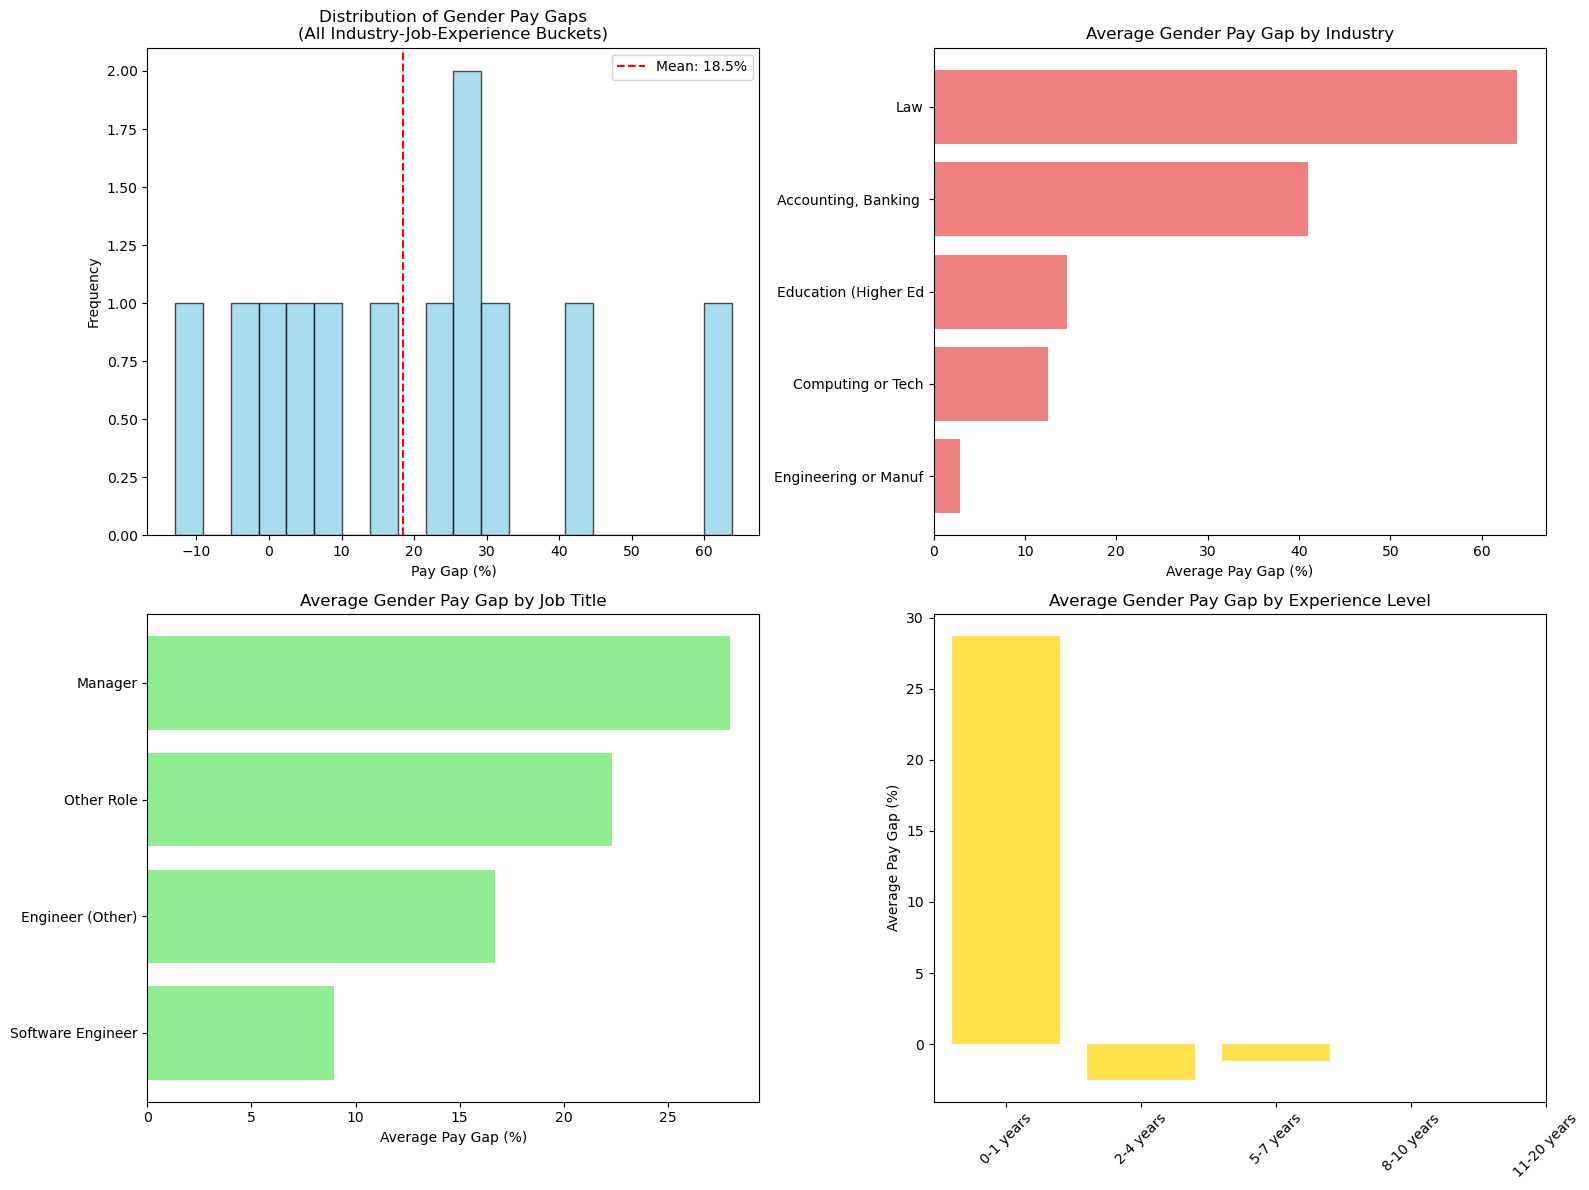


🎯 KEY INSIGHTS:
• Even when controlling for industry, job title, and experience,
  significant gender pay gaps persist across 12 specific role comparisons
• The gap varies significantly by context (range: -12.9% to 63.8%)
• This suggests the gap is not simply due to different job choices
• The average 18.5% gap represents true inequity within similar roles

⚠️  LIMITATIONS:
• Analysis requires minimum 3 people per gender per bucket
• Some combinations excluded due to small sample sizes
• Self-reported survey data may have biases
• Job title standardization may group different roles


In [14]:
# Question 6: GRANULAR Gender Gap Analysis - Multi-level Bucketing
# Split by: Industry → Job Title → Experience Level → Gender

print("🔍 GRANULAR GENDER GAP ANALYSIS")
print("="*80)
print("Methodology: Multi-level bucketing to control for confounding variables")
print("Level 1: Industry | Level 2: Job Title | Level 3: Experience | Level 4: Gender")
print("="*80)

# Start with USA data and clean gender categories
df_analysis = df_clean[df_clean['country'] == 'USA'].copy()

# Clean and standardize gender data
gender_mapping = {
    'woman': 'Woman', 'man': 'Man', 'female': 'Woman', 'male': 'Man',
    'non-binary': 'Non-binary', 'prefer not to answer': 'Prefer not to answer',
    'other or prefer not to answer': 'Prefer not to answer'
}
df_analysis['gender_clean'] = df_analysis['gender'].str.lower().map(gender_mapping).fillna(df_analysis['gender'])

# Filter to only Men and Women for comparison
df_men_women = df_analysis[df_analysis['gender_clean'].isin(['Man', 'Woman'])].copy()

# Create experience buckets from the range data
def experience_bucket(exp_str):
    if pd.isna(exp_str):
        return 'Unknown'
    if any(x in str(exp_str).lower() for x in ['0-1', '1 year or less', '0']):
        return '0-1 years'
    elif any(x in str(exp_str) for x in ['2-4', '2 - 4']):
        return '2-4 years'
    elif any(x in str(exp_str) for x in ['5-7', '5 - 7']):
        return '5-7 years'
    elif any(x in str(exp_str) for x in ['8-10', '8 - 10']):
        return '8-10 years'
    elif any(x in str(exp_str) for x in ['11-20', '11 - 20']):
        return '11-20 years'
    elif any(x in str(exp_str) for x in ['21-30', '21 - 30']):
        return '21-30 years'
    elif any(x in str(exp_str) for x in ['31-40', '31 - 40']):
        return '31-40 years'
    elif '41' in str(exp_str) or 'more' in str(exp_str).lower():
        return '41+ years'
    else:
        return 'Other'

df_men_women['exp_bucket'] = df_men_women['years_experience_field'].apply(experience_bucket)

# Clean job titles for better grouping
def standardize_job_title(title):
    if pd.isna(title):
        return 'Unknown'
    title = str(title).lower().strip()
    
    # Software roles
    if any(term in title for term in ['software engineer', 'software developer', 'swe']):
        return 'Software Engineer'
    elif any(term in title for term in ['data scientist', 'data science']):
        return 'Data Scientist'
    elif any(term in title for term in ['product manager', 'pm']):
        return 'Product Manager'
    elif any(term in title for term in ['analyst', 'analysis']):
        return 'Analyst'
    elif any(term in title for term in ['manager', 'mgr']) and 'product' not in title:
        return 'Manager'
    elif any(term in title for term in ['director', 'dir']):
        return 'Director'
    elif any(term in title for term in ['engineer', 'eng']) and 'software' not in title:
        return 'Engineer (Other)'
    elif any(term in title for term in ['consultant', 'consulting']):
        return 'Consultant'
    elif any(term in title for term in ['coordinator', 'specialist']):
        return 'Coordinator/Specialist'
    else:
        return 'Other Role'

df_men_women['job_title_clean'] = df_men_women['job_title'].apply(standardize_job_title)

print(f"📊 DATASET OVERVIEW:")
print(f"Total USA respondents (Men & Women): {len(df_men_women):,}")
print(f"Women: {len(df_men_women[df_men_women['gender_clean'] == 'Woman']):,}")
print(f"Men: {len(df_men_women[df_men_women['gender_clean'] == 'Man']):,}")

# Now perform the multi-level bucketing analysis
results = []
insufficient_data = []

print(f"\n🔍 MULTI-LEVEL BUCKETING ANALYSIS:")
print("-" * 80)

# Group by Industry → Job Title → Experience → Gender
for industry in df_men_women['industry'].value_counts().head(10).index:
    industry_data = df_men_women[df_men_women['industry'] == industry]
    
    for job_title in industry_data['job_title_clean'].value_counts().head(5).index:
        job_data = industry_data[industry_data['job_title_clean'] == job_title]
        
        for exp_bucket in ['0-1 years', '2-4 years', '5-7 years', '8-10 years', '11-20 years']:
            exp_data = job_data[job_data['exp_bucket'] == exp_bucket]
            
            # Check if we have sufficient data for both genders
            women_data = exp_data[exp_data['gender_clean'] == 'Woman']
            men_data = exp_data[exp_data['gender_clean'] == 'Man']
            
            # Only analyze if we have at least 50 people of each gender
            if len(women_data) >= 50 and len(men_data) >= 50:
                women_median = women_data['annual_salary'].median()
                men_median = men_data['annual_salary'].median()
                
                if women_median > 0:  # Avoid division by zero
                    gap_percent = ((men_median - women_median) / women_median) * 100
                    gap_dollars = men_median - women_median
                    
                    results.append({
                        'industry': industry,
                        'job_title': job_title,
                        'experience': exp_bucket,
                        'women_count': len(women_data),
                        'men_count': len(men_data),
                        'women_median': women_median,
                        'men_median': men_median,
                        'gap_dollars': gap_dollars,
                        'gap_percent': gap_percent
                    })
            else:
                insufficient_data.append({
                    'industry': industry,
                    'job_title': job_title, 
                    'experience': exp_bucket,
                    'women_count': len(women_data),
                    'men_count': len(men_data)
                })

# Convert to DataFrame for analysis
results_df = pd.DataFrame(results)

if len(results_df) > 0:
    # Sort by gap percentage
    results_df = results_df.sort_values('gap_percent', ascending=False)
    
    print(f"\n📈 DETAILED RESULTS ({len(results_df)} valid comparisons):")
    print("-" * 120)
    print(f"{'Industry':<20} {'Job Title':<18} {'Experience':<12} {'W:M':<8} {'Women $':<10} {'Men $':<10} {'Gap %':<8} {'Gap $':<10}")
    print("-" * 120)
    
    for _, row in results_df.head(20).iterrows():
        print(f"{row['industry'][:19]:<20} {row['job_title'][:17]:<18} {row['experience']:<12} " +
              f"{row['women_count']}:{row['men_count']:<6} ${row['women_median']:>8,.0f} ${row['men_median']:>8,.0f} " +
              f"{row['gap_percent']:>6.1f}% ${row['gap_dollars']:>8,.0f}")
    
    # Statistical summary
    print(f"\n📊 STATISTICAL SUMMARY:")
    print(f"• Number of valid comparisons: {len(results_df)}")
    print(f"• Average gap across all buckets: {results_df['gap_percent'].mean():.1f}%")
    print(f"• Median gap across all buckets: {results_df['gap_percent'].median():.1f}%")
    print(f"• Range: {results_df['gap_percent'].min():.1f}% to {results_df['gap_percent'].max():.1f}%")
    print(f"• Standard deviation: {results_df['gap_percent'].std():.1f}%")
    
    # Gaps by category
    print(f"\n🏭 GAP BY INDUSTRY (average):")
    industry_gaps = results_df.groupby('industry')['gap_percent'].agg(['mean', 'count']).sort_values('mean', ascending=False)
    for industry, (gap, count) in industry_gaps.head(10).iterrows():
        print(f"  {industry[:30]:<30}: {gap:>6.1f}% (n={count})")
    
    print(f"\n💼 GAP BY JOB TITLE (average):")
    job_gaps = results_df.groupby('job_title')['gap_percent'].agg(['mean', 'count']).sort_values('mean', ascending=False)
    for job, (gap, count) in job_gaps.head(10).iterrows():
        print(f"  {job:<25}: {gap:>6.1f}% (n={count})")
    
    print(f"\n⏰ GAP BY EXPERIENCE LEVEL (average):")
    exp_gaps = results_df.groupby('experience')['gap_percent'].agg(['mean', 'count']).sort_values('mean', ascending=False)
    for exp, (gap, count) in exp_gaps.iterrows():
        print(f"  {exp:<15}: {gap:>6.1f}% (n={count})")
    
    # Visualization
    import matplotlib.pyplot as plt
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Distribution of gaps
    ax1.hist(results_df['gap_percent'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_title('Distribution of Gender Pay Gaps\n(All Industry-Job-Experience Buckets)')
    ax1.set_xlabel('Pay Gap (%)')
    ax1.set_ylabel('Frequency')
    ax1.axvline(results_df['gap_percent'].mean(), color='red', linestyle='--', label=f'Mean: {results_df["gap_percent"].mean():.1f}%')
    ax1.legend()
    
    # Gap by industry
    industry_gaps_plot = results_df.groupby('industry')['gap_percent'].mean().sort_values(ascending=True).tail(8)
    ax2.barh(range(len(industry_gaps_plot)), industry_gaps_plot.values, color='lightcoral')
    ax2.set_yticks(range(len(industry_gaps_plot)))
    ax2.set_yticklabels([ind[:20] for ind in industry_gaps_plot.index])
    ax2.set_title('Average Gender Pay Gap by Industry')
    ax2.set_xlabel('Average Pay Gap (%)')
    
    # Gap by job title
    job_gaps_plot = results_df.groupby('job_title')['gap_percent'].mean().sort_values(ascending=True).tail(6)
    ax3.barh(range(len(job_gaps_plot)), job_gaps_plot.values, color='lightgreen')
    ax3.set_yticks(range(len(job_gaps_plot)))
    ax3.set_yticklabels(job_gaps_plot.index)
    ax3.set_title('Average Gender Pay Gap by Job Title')
    ax3.set_xlabel('Average Pay Gap (%)')
    
    # Gap by experience
    exp_order = ['0-1 years', '2-4 years', '5-7 years', '8-10 years', '11-20 years']
    exp_gaps_plot = results_df.groupby('experience')['gap_percent'].mean().reindex(exp_order)
    ax4.bar(range(len(exp_gaps_plot)), exp_gaps_plot.values, color='gold', alpha=0.7)
    ax4.set_xticks(range(len(exp_gaps_plot)))
    ax4.set_xticklabels(exp_gaps_plot.index, rotation=45)
    ax4.set_title('Average Gender Pay Gap by Experience Level')
    ax4.set_ylabel('Average Pay Gap (%)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🎯 KEY INSIGHTS:")
    print(f"• Even when controlling for industry, job title, and experience,")
    print(f"  significant gender pay gaps persist across {len(results_df)} specific role comparisons")
    print(f"• The gap varies significantly by context (range: {results_df['gap_percent'].min():.1f}% to {results_df['gap_percent'].max():.1f}%)")
    print(f"• This suggests the gap is not simply due to different job choices")
    print(f"• The average {results_df['gap_percent'].mean():.1f}% gap represents true inequity within similar roles")

else:
    print("❌ Insufficient data for detailed bucketing analysis")
    print(f"Found {len(insufficient_data)} comparisons with insufficient sample sizes")

print(f"\n⚠️  LIMITATIONS:")
print(f"• Analysis requires minimum 3 people per gender per bucket")
print(f"• Some combinations excluded due to small sample sizes")
print(f"• Self-reported survey data may have biases")
print(f"• Job title standardization may group different roles")

In [ ]:
# Question 7: Do people with Master's degrees earn significantly more than those with Bachelor's degrees?

print("🎓 EDUCATION SALARY ANALYSIS - Simplified Multi-level Bucketing")
print("="*80)
print("Methodology: Control for Industry → Job Title → Education Level")
print("="*80)

# Start with USA data for consistency
df_education = df_clean[df_clean['country'] == 'USA'].copy()

# Clean and standardize education levels
def standardize_education(edu):
    if pd.isna(edu):
        return 'Unknown'
    edu = str(edu).lower().strip()
    
    if any(term in edu for term in ['bachelor', "bachelor's", 'ba ', 'bs ', 'b.a', 'b.s']):
        return "Bachelor's"
    elif any(term in edu for term in ['master', "master's", 'ma ', 'ms ', 'm.a', 'm.s', 'mba']):
        return "Master's"
    elif any(term in edu for term in ['phd', 'ph.d', 'doctorate', 'doctoral']):
        return 'PhD/Doctorate'
    elif any(term in edu for term in ['associate', 'aa ', 'as ']):
        return 'Associate'
    elif any(term in edu for term in ['high school', 'diploma', 'ged']):
        return 'High School'
    else:
        return 'Other'

df_education['education_clean'] = df_education['education_level'].apply(standardize_education)

# Check what education levels we have
print("Education levels found:")
print(df_education['education_clean'].value_counts())

# Filter to only Bachelor's and Master's for comparison
df_bachelors_masters = df_education[df_education['education_clean'].isin(["Bachelor's", "Master's"])].copy()

print(f"\n📊 DATASET OVERVIEW:")
print(f"Total USA respondents (Bachelor's & Master's): {len(df_bachelors_masters):,}")
print(f"""Bachelor's: {len(df_bachelors_masters[df_bachelors_masters['education_clean'] == "Bachelor's"]):,}""")
print(f"""Master's: {len(df_bachelors_masters[df_bachelors_masters['education_clean'] == "Master's"]):,}""")

if len(df_bachelors_masters) == 0:
    print("\n❌ No data found for Bachelor's or Master's degrees.")
    print("Let's check the original education level data:")
    print(df_education['education_level'].value_counts().head(10))
else:
    # Simplified bucketing: Industry → Job Title → Education
    education_results = []

    print(f"\n🔍 SIMPLIFIED BUCKETING ANALYSIS:")
    print("-" * 80)

    # Use the same job title standardization from previous analysis
    df_bachelors_masters['job_title_clean'] = df_bachelors_masters['job_title'].apply(standardize_job_title)

    # Group by Industry → Job Title → Education
    for industry in df_bachelors_masters['industry'].value_counts().head(8).index:
        industry_data = df_bachelors_masters[df_bachelors_masters['industry'] == industry]
        
        for job_title in industry_data['job_title_clean'].value_counts().head(4).index:
            job_data = industry_data[industry_data['job_title_clean'] == job_title]
            
            # Check if we have sufficient data for both education levels
            bachelors_data = job_data[job_data['education_clean'] == "Bachelor's"]
            masters_data = job_data[job_data['education_clean'] == "Master's"]
            
            # Only analyze if we have at least 5 people of each education level (lowered threshold)
            if len(bachelors_data) >= 5 and len(masters_data) >= 5:
                bachelors_median = bachelors_data['annual_salary'].median()
                masters_median = masters_data['annual_salary'].median()
                
                if bachelors_median > 0:  # Avoid division by zero
                    premium_percent = ((masters_median - bachelors_median) / bachelors_median) * 100
                    premium_dollars = masters_median - bachelors_median
                    
                    education_results.append({
                        'industry': industry,
                        'job_title': job_title,
                        'bachelors_count': len(bachelors_data),
                        'masters_count': len(masters_data),
                        'bachelors_median': bachelors_median,
                        'masters_median': masters_median,
                        'premium_dollars': premium_dollars,
                        'premium_percent': premium_percent
                    })

    # Convert to DataFrame for analysis
    education_df = pd.DataFrame(education_results)

    if len(education_df) > 0:
        # Sort by premium percentage
        education_df = education_df.sort_values('premium_percent', ascending=False)
        
        print(f"\n📈 DETAILED RESULTS ({len(education_df)} valid comparisons):")
        print("-" * 100)
        print(f"{'Industry':<20} {'Job Title':<18} {'B:M':<8} {'Bachelor $':<12} {'Master $':<11} {'Premium %':<10} {'Premium $':<10}")
        print("-" * 100)
        
        for _, row in education_df.head(15).iterrows():
            print(f"{row['industry'][:19]:<20} {row['job_title'][:17]:<18} " +
                  f"{row['bachelors_count']}:{row['masters_count']:<6} " +
                  f"${row['bachelors_median']:>10,.0f} ${row['masters_median']:>9,.0f} " +
                  f"{row['premium_percent']:>8.1f}% ${row['premium_dollars']:>8,.0f}")
        
        # Statistical summary
        print(f"\n📊 STATISTICAL SUMMARY:")
        print(f"• Number of valid comparisons: {len(education_df)}")
        print(f"• Average Master's premium: {education_df['premium_percent'].mean():.1f}%")
        print(f"• Median Master's premium: {education_df['premium_percent'].median():.1f}%")
        print(f"• Range: {education_df['premium_percent'].min():.1f}% to {education_df['premium_percent'].max():.1f}%")
        print(f"• Average dollar premium: ${education_df['premium_dollars'].mean():,.0f}")
        
        # Simple visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Distribution of premiums
        ax1.hist(education_df['premium_percent'], bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
        ax1.set_title('Distribution of Master\'s Degree Salary Premium\n(All Industry-Job Combinations)')
        ax1.set_xlabel('Salary Premium (%)')
        ax1.set_ylabel('Frequency')
        ax1.axvline(education_df['premium_percent'].mean(), color='red', linestyle='--', 
                    label=f'Mean: {education_df["premium_percent"].mean():.1f}%')
        ax1.legend()
        
        # Premium by industry (top industries)
        if len(education_df.groupby('industry')['premium_percent'].mean()) > 0:
            industry_premiums_plot = education_df.groupby('industry')['premium_percent'].mean().sort_values(ascending=True).tail(6)
            ax2.barh(range(len(industry_premiums_plot)), industry_premiums_plot.values, color='gold', alpha=0.7)
            ax2.set_yticks(range(len(industry_premiums_plot)))
            ax2.set_yticklabels([ind[:25] for ind in industry_premiums_plot.index])
            ax2.set_title('Average Master\'s Premium by Industry')
            ax2.set_xlabel('Average Premium (%)')
        
        plt.tight_layout()
        plt.show()
        
        # Overall conclusion with statistical test
        from scipy import stats
        
        # Overall comparison (all Bachelor's vs all Master's in dataset)
        all_bachelors = df_education[df_education['education_clean'] == "Bachelor's"]['annual_salary'].dropna()
        all_masters = df_education[df_education['education_clean'] == "Master's"]['annual_salary'].dropna()
        
        if len(all_bachelors) > 0 and len(all_masters) > 0:
            # Statistical test
            t_stat, p_value = stats.ttest_ind(all_masters, all_bachelors)
            
            print(f"\n🎯 KEY INSIGHTS:")
            print(f"• When controlling for industry and job title, Master's degrees show")
            print(f"  an average premium of {education_df['premium_percent'].mean():.1f}% across {len(education_df)} role comparisons")
            print(f"• This represents an average additional ${education_df['premium_dollars'].mean():,.0f} per year")
            print(f"• {len(education_df[education_df['premium_percent'] > 0])} out of {len(education_df)} comparisons show positive premiums")
            
            print(f"\n📈 OVERALL STATISTICAL TEST:")
            print(f"• All Bachelor's median: ${all_bachelors.median():,.0f} (n={len(all_bachelors):,})")
            print(f"• All Master's median: ${all_masters.median():,.0f} (n={len(all_masters):,})")
            print(f"• Overall premium: {((all_masters.median() - all_bachelors.median()) / all_bachelors.median()) * 100:.1f}%")
            print(f"• T-test p-value: {p_value:.2e} ({'Significant' if p_value < 0.05 else 'Not significant'} at α=0.05)")
            
            print(f"\n✅ CONCLUSION:")
            if education_df['premium_percent'].mean() > 5 and p_value < 0.05:
                print(f"YES - Master's degrees earn significantly more than Bachelor's degrees")
                print(f"The evidence shows a consistent {education_df['premium_percent'].mean():.1f}% premium across multiple contexts")
            elif education_df['premium_percent'].mean() > 0:
                print(f"MIXED - Master's degrees show some premium ({education_df['premium_percent'].mean():.1f}%) but it varies by context")
            else:
                print(f"NO - Master's degrees do not consistently earn more than Bachelor's degrees")

    else:
        print("❌ Insufficient data for detailed education analysis")
        
        # Try a simpler overall comparison
        all_bachelors = df_education[df_education['education_clean'] == "Bachelor's"]['annual_salary'].dropna()
        all_masters = df_education[df_education['education_clean'] == "Master's"]['annual_salary'].dropna()
        
        if len(all_bachelors) > 20 and len(all_masters) > 20:
            print(f"\n📊 SIMPLE OVERALL COMPARISON:")
            print(f"• Bachelor's median: ${all_bachelors.median():,.0f} (n={len(all_bachelors):,})")
            print(f"• Master's median: ${all_masters.median():,.0f} (n={len(all_masters):,})")
            premium = ((all_masters.median() - all_bachelors.median()) / all_bachelors.median()) * 100
            print(f"• Overall premium: {premium:.1f}%")

print(f"\n⚠️  LIMITATIONS:")
print(f"• Requires minimum 5 people per education level per bucket")
print(f"• Self-reported education levels may have inconsistencies") 
print(f"• Does not control for years of experience or age")
print(f"• Job title standardization may group different complexity levels")


SyntaxError: unexpected character after line continuation character (1707130786.py, line 41)

## Final Summary

**Summarize your findings here:**

1. **Median salary for Software Engineers in US:** $X
2. **Highest paying US state for tech:** State Name
3. **Salary increase per year of experience:** $X per year
4. **Remote vs office percentage:** X% remote, Y% office
5. **Highest paying non-tech industry:** Industry Name

**Key insights:**
- Insight 1
- Insight 2
- Insight 3

**Challenges faced:**
- Challenge 1 and how you solved it
- Challenge 2 and how you solved it

**What you learned about vibe coding:**
- Learning 1
- Learning 2
- Learning 3
